In [1]:
from __future__ import division
import os, sys
import warnings
os.environ["SDL_VIDEODRIVER"] = "dummy"
sys.path.append("..")
warnings.filterwarnings('ignore')

import psutil
import gc
import gym
import dmc2gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import count
from gym import spaces
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

from src.networks import FeedForwardNet, FeedForwardNet_v2, EnvModel, Critic
from src.replay_buffer import Replay_buffer
from src.utils import fanin_init, weights_init_normal, Average, freeze, unfreeze

## Initialize environment and parameters

In [2]:
batch_size = 100
lr = 0.0001
hidden_size = 200
model_hidden_size = 32
max_episodes = 1000
max_steps = 1000
max_buffer = 1000000
device = 'cuda'
use_pretrained_model = True
domain_name = 'cartpole'
task_name = 'balance'
agent_name = f'{domain_name}_{task_name}_hs{model_hidden_size}'

env = dmc2gym.make(domain_name=domain_name, task_name=task_name, seed=1)
env.seed(2023)
torch.manual_seed(2023)
np.random.seed(2023)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
q_dim = 1 
max_action = float(env.action_space.high[0])
min_Val = torch.tensor(1e-7).float().to(device) # min value

/home/arkadiy/.local/lib/python3.8/site-packages/dmc2gym/wrappers.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim = np.int(np.prod(s.shape))
/home/arkadiy/.local/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/arkadiy/.local/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarn

## Build solver

In [3]:
class LPModel(object):
    def __init__(self, state_dim, action_dim, q_dim, hidden_size=32, model_hidden_size=300, lr=1e-3, batch_size=1, device='cuda'): 
        
        self.device = device
        self.q_dim = q_dim
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.batch_size = batch_size
        self.num_model_update_iteration = 0
        self.policy_update_iterations = 200
        self.model_update_iterations = 200
        self.critic_update_iteration = 200
        self.tau = 0.005
        self.gamma = 0.99
        
        self.policy = FeedForwardNet_v2(state_dim, q_dim, action_dim, hidden_size).to(self.device)
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr)
        
        self.potential = FeedForwardNet(state_dim, action_dim, hidden_size).to(self.device)
        self.potential_optimizer = torch.optim.Adam(self.potential.parameters(), lr)
        
        self.model = TransitionModel(state_dim, action_dim, model_hidden_size*2, model_hidden_size).to(self.device)
        self.model_optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.model_loss = nn.MSELoss()
        
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        self.replay_buffer = Replay_buffer(max_size=1000000)

    def select_action(self, state):
        q = torch.randn(1, self.q_dim).to(self.device)
        state = Variable(torch.from_numpy(np.float32(state))).reshape(1, -1).to(self.device)
        action = self.policy(state,q)
        #action = torch.clamp(action, -1, 1)
        return action.cpu().data.numpy().flatten()
    
    def critic_update(self):
        unfreeze(self.critic)
        for it in range(self.critic_update_iteration):
            # Sample replay buffer
            x, y, u, r, d = self.replay_buffer.sample(self.batch_size)
            state = torch.FloatTensor(x).to(self.device)
            action = torch.FloatTensor(u).to(self.device)
            next_state = torch.FloatTensor(y).to(self.device)
            done = torch.FloatTensor(1-d).to(self.device)
            reward = torch.FloatTensor(r).to(self.device)
            q = torch.randn(self.batch_size, self.q_dim).to(self.device)

            # Compute the target Q value
            target_Q = self.critic_target(next_state, self.policy(next_state,q))
            target_Q = reward #+ (done * self.gamma * target_Q).detach()

            # Get current Q estimate
            current_Q = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)
            #self.writer.add_scalar('Loss/critic_loss', critic_loss, global_step=self.num_critic_update_iteration)
            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    
    def update(self):
        ploss = []
        floss = []
        for it in range(self.policy_update_iterations):
            unfreeze(self.policy); freeze(self.potential)#; freeze(self.model); freeze(self.critic)
            
            x, y, _, _, _ = self.replay_buffer.sample(self.batch_size)
            state = torch.FloatTensor(x).to(self.device)
            #next_state = torch.FloatTensor(y).to(self.device)
            
            q = torch.randn(self.batch_size, self.q_dim).to(self.device)
            action = self.policy(state,q)
            next_state, r, _ = self.model(state,action)
            #P_loss = -self.critic(state,action).mean() + self.potential(state).mean() - self.potential(next_state).mean()
            P_loss = -r.mean() + self.potential(state).mean() - self.potential(next_state).mean()
            self.policy_optimizer.zero_grad()
            P_loss.backward()
            self.policy_optimizer.step()
            ploss.append(P_loss)
            
            freeze(self.policy); unfreeze(self.potential)
            x, y, _, _, _ = self.replay_buffer.sample(self.batch_size)
            state = torch.FloatTensor(x).to(self.device)
            #next_state = torch.FloatTensor(y).to(self.device)
            q = torch.randn(self.batch_size, self.q_dim).to(self.device)
            with torch.no_grad(): 
                action = self.policy(state,q)
                next_state, _, _ = self.model(state,action)
            f_loss = self.potential(state).mean() - self.potential(next_state).mean()
            f_loss = -f_loss
            self.potential_optimizer.zero_grad()
            f_loss.backward() 
            self.potential_optimizer.step()
            floss.append(f_loss)
            
        return action, ploss, floss
            
            
    def env_update(self):
        for it in range(self.model_update_iterations):
            unfreeze(self.model);
            x, y, u, r, d = self.replay_buffer.sample(self.batch_size)
            state = torch.FloatTensor(x).to(self.device)
            action = torch.FloatTensor(u).reshape(self.batch_size, self.action_dim).to(self.device)
            next_state = torch.FloatTensor(y).to(self.device)
            done = torch.FloatTensor(1-d).to(self.device)
            reward = torch.FloatTensor(r).to(self.device)
            
            #action = action.reshape(self.batch_size, self.action_dim)
            #action = action[:,None]
            
            state_, reward_, done_ = self.model(state, action)
            loss_s = self.model_loss(state_, next_state)
            loss_r = self.model_loss(reward_, reward)
            loss_d = self.model_loss(done_, done)

            self.model_optimizer.zero_grad()
            loss = loss_s+loss_r+loss_d
            loss.backward()
            self.model_optimizer.step()
            self.num_model_update_iteration += 1
            
    def evaluate(self, policy, env):
        best_ep_r = 0
        total_reward = 0
        for i_episode in range(10):
            state = env.reset()
            ep_r = 0
            timestep = 0
            rwd_dyna = []
            total_steps = 0
            while True:
                total_steps += 1
                # env.render()
                state = Variable(torch.from_numpy(np.float32(state))).reshape(1, self.state_dim).to(self.device)
                q = torch.randn(1, self.q_dim).to(self.device)
                action = policy(state,q)
                #a = torch.clamp(a, min=0, max=1) 
                #action = torch.clamp(action, -1, 1)   
                s_, r, done, info = env.step(action.cpu().detach().numpy()[0])
                ep_r += r
                if done:
                    break
                state = s_
            total_reward += ep_r
            if ep_r > best_ep_r:
                best_ep_r = ep_r
        print('Total reward:', total_reward)
        print('Best achieved reward:', best_ep_r)
        return best_ep_r
            

    def save(self):
        torch.save(self.policy.state_dict(), directory + 'policy.pth')
        torch.save(self.potential.state_dict(), directory + 'potential.pth')
        torch.save(self.model.state_dict(), directory + 'model.pth')
        print("====================================")
        print("Model has been saved...")
        print("====================================")

    def load(self):
        self.policy.load_state_dict(torch.load(directory + 'policy.pth'))
        self.potential.load_state_dict(torch.load(directory + 'potential.pth'))
        self.model.load_state_dict(torch.load(directory + 'model.pth'))
        print("====================================")
        print("models has been loaded...")
        print("====================================")

In [4]:
if use_pretrained_model:
    agent = LPModel(state_dim, action_dim, q_dim, hidden_size, model_hidden_size, lr, batch_size, device)
    model_name = agent_name+'_model.pt'
    policy_name = agent_name+'_best_policy.pt'
    agent.model.load_state_dict(torch.load(f'/home/jovyan/LinearProgrammingRL/saved_models/{model_name}'))
    train_worldmodel = False
    freeze(agent.model) 
else:
    agent = LPModel(state_dim, action_dim, q_dim, hidden_size, model_hidden_size, lr, batch_size, device)
    train_worldmodel = True 

NameError: name 'TransitionModel' is not defined

## Train

In [77]:
rewards = []
ploss = []
dloss = []
total_reward = 0
total_step = 0
best_reward = 0

for episode in tqdm(range(max_episodes)):
    state = env.reset()
    for step in range(max_steps): 
        #action, ploss, floss = agent.update(state)
        action = agent.select_action(state)  
        next_state, reward, done, info = env.step(action)
        agent.replay_buffer.push((state, next_state, action, reward, np.float(done)))
        
        state = next_state
        total_step+=1
        total_reward +=reward
        #_, ploss, floss = agent.update(None)
        if done:
            break
    rewards.append(total_reward)
    _, ploss, floss = agent.update()
    #agent.critic_update()
    agent.env_update()
    #if train_worldmodel:
    #    agent.env_update()
            
    print("Total T:{} Episode: \t{} Total Reward: \t{:0.2f}".format(total_step, episode, total_reward))
    total_reward=0
    if episode % 50 == 0:
        print('Ploss', Average(ploss).item())
        #print('Floss', Average(floss).item())
        achieved_reward = agent.evaluate(agent.policy, env)
        if achieved_reward> best_reward:
            best_reward = achieved_reward
            #torch.save(agent.policy.state_dict(), f'/home/jovyan/LinearProgrammingRL/saved_models/{policy_name}')
        print("--------------------------------")
        gc.collect(); torch.cuda.empty_cache()

  0%|          | 0/1000 [00:00<?, ?it/s]

Total T:1000 Episode: 	0 Total Reward: 	436.83
Ploss -0.441589891910553
Total reward: 2673.0177362067907
Best achieved reward: 289.62543344323865
--------------------------------
Total T:2000 Episode: 	1 Total Reward: 	327.79
Total T:3000 Episode: 	2 Total Reward: 	356.36
Total T:4000 Episode: 	3 Total Reward: 	384.20
Total T:5000 Episode: 	4 Total Reward: 	388.14
Total T:6000 Episode: 	5 Total Reward: 	309.14
Total T:7000 Episode: 	6 Total Reward: 	304.55
Total T:8000 Episode: 	7 Total Reward: 	256.18
Total T:9000 Episode: 	8 Total Reward: 	254.37
Total T:10000 Episode: 	9 Total Reward: 	258.84
Total T:11000 Episode: 	10 Total Reward: 	315.31
Total T:12000 Episode: 	11 Total Reward: 	231.66
Total T:13000 Episode: 	12 Total Reward: 	318.29
Total T:14000 Episode: 	13 Total Reward: 	211.53
Total T:15000 Episode: 	14 Total Reward: 	194.05
Total T:16000 Episode: 	15 Total Reward: 	150.62
Total T:17000 Episode: 	16 Total Reward: 	175.59
Total T:18000 Episode: 	17 Total Reward: 	262.70
Total

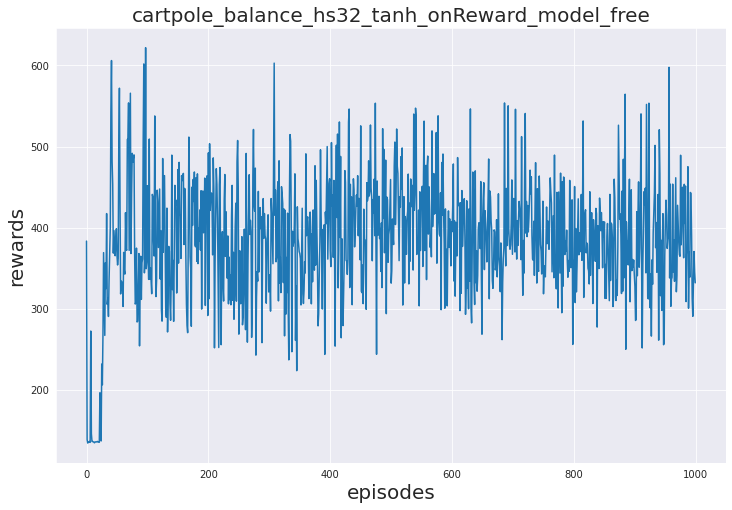

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


experiment_name = f'{domain_name}_{task_name}_hs{model_hidden_size}_tanh_onReward_model_free'


sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.title(experiment_name, size=20)
plt.xlabel("episodes", size=20)
plt.ylabel("rewards", size=20)
plt.plot(rewards[:2000])
plt.savefig(f'/home/jovyan/LinearProgrammingRL/plots/{experiment_name}')
plt.show()

# The main problem here is a wrong model
## There is few variations of this algorithm
### 1) s the ground true: T(s,q) and model of reward, and transition model P(s'|s,a)
### 2) s the ground true: T(s,q) the value function instean of the model of reward, and transition model P(s'|s,a)
### 3) s from the env, the value function instean of the model of reward, and transition model P(s'|s,a)
### 4) s from env, model of reward, env instead of the transition model
### 5) s from env, the value function instean of the model of reward, env instead of the transition model

## I think we need compare the 1st, the4th(fully model free) and 5 if 4 will not work, model free but the value to make it works